# Design and operations of energy technologies for a household (PV, heat pump, battery)


In this case study we find the optimal sizes and operations of a heat pump, a set of solar panels and a battery to power the energy needs (heat and electricity) of a household over 1 year. The household, which has certain heat and electricity demand profiles, has an existing connection to the grid and an existing gas boiler. The emissions of CO2 are taxed.

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [1]:
import adopt_net0 as adopt
import json
import pandas as pd
from pathlib import Path
import numpy as np

input_data_path = Path("./caseStudies/household")
adopt.create_optimization_templates(input_data_path)

Files already exist: caseStudies\household\Topology.json caseStudies\household\ConfigModel.json


## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here, via some lines of code.
For the topology, we need to change the following:
- Change nodes: household
- Change carriers: electricity, heat and gas
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [2]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["household"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "gas"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)


## Adapt Model Configurations
Now, we need to adapt the model configurations respectively. In this case, we don't use any particular algorithm (clustering, time staging etc), so here we only specify what we want to minimize - costs in this example - and set the gap for the MILP solver to a desired value. 


In [3]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Change objective
configuration["optimization"]["objective"]["value"] = "costs"
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define input data
We first create all required input data files based on the topology file and then add the existing technologies (gas boiler, 3kW capacity) and potential new technologies (heat pump, PV, battery). Since we have potentially a PV, we need to specify the location of the household.
Additionally, we copy over technology data to the input data folder


In [4]:
adopt.create_input_data_folder_template(input_data_path)

# Add heat pump, PV and battery as new technologies
with open(input_data_path / "period1" / "node_data" / "household" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["Photovoltaic","HeatPump_AirSourced","Storage_Battery"]
technologies["existing"] = {"Boiler_Small_NG": 0.003}

with open(input_data_path / "period1" / "node_data" / "household" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

# Specify location of the household
node_location = pd.read_csv(input_data_path / "NodeLocations.csv", sep=';', index_col=0, header=0)
node_lon = 4.9
node_lat = 52
node_alt = 10
node_name = 'household'
node_location.at['household', 'lon'] = node_lon
node_location.at['household', 'lat'] = node_lat
node_location.at['household', 'alt'] = node_alt
node_location = node_location.reset_index()
node_location.to_csv(input_data_path / "NodeLocations.csv", sep=';', index=False)


## Read demand data, import limits/price
In this case study we want to model an hourly heat and electricity demand of the household, with variable electricity prices. In addition, we set a fixed value for gas and electricity import limits and gas prices. As such we:
- Read day-ahead electricity prices (hourly for the Netherlands in 2023)
- Read hourly heat (total 7.3MWh) and electricity demand (total 4MWh)
- Limit import of gas (5kW) and electricity (8kW)
- Set an import price on gas of 120 EUR/MWh

Finally, we set a carbon tax to 100 EUR/t.

N.B all the data should be in MW, EUR/MWh, EUR/t, t/MWh

In [5]:
# Read hourly data from Excel
user_input_path = "./caseStudies/data/data_household.xlsx"
household_hourly_data = pd.read_excel(user_input_path, header=0, nrows=8760)

# Save the hourly data to the carrier's file in the case study folder
# electricity demand and price
el_price = household_hourly_data.iloc[:, 2]
el_demand = household_hourly_data.iloc[:, 1]
heat_demand = household_hourly_data.iloc[:, 0]
adopt.fill_carrier_data(input_data_path, value_or_data=el_price, columns=['Import price'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=el_price, columns=['Export price'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=el_demand, columns=['Demand'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=heat_demand, columns=['Demand'], carriers=['heat'], nodes=['household'])

# Set import limits/cost
adopt.fill_carrier_data(input_data_path, value_or_data=0.005, columns=['Import limit'], carriers=['gas'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=0.008, columns=['Import limit'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=120, columns=['Import price'], carriers=['gas'], nodes=['household'])

# Set carbon emission price
carbon_price = np.ones(8760)*100
carbon_cost_path = "./caseStudies/household/period1/node_data/household/CarbonCost.csv"
carbon_cost_template = pd.read_csv(carbon_cost_path, sep=';', index_col=0, header=0)
carbon_cost_template['price'] = carbon_price
carbon_cost_template = carbon_cost_template.reset_index()
carbon_cost_template.to_csv(carbon_cost_path, sep=';', index=False)

## Run model
Now, we have defined all required data to run the model

In [6]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

INFO:--- Reading in data ---
INFO:Input data folder has been checked successfully - no errors occurred.
INFO:Topology read successfully
INFO:Model Configuration read successfully
INFO:Model Configuration used: {"optimization": {"objective": {"description": "String specifying the objective/type of optimization.", "options": ["costs", "emissions_pos", "emissions_net", "emissions_minC", "costs_emissionlimit", "pareto"], "value": "costs"}, "emission_limit": {"description": "emission limit to be enforced if objective function is costs_emissionlimit", "value": 0}, "monte_carlo": {"N": {"description": "Number of Monte Carlo simulations (0 = off).", "value": 0}, "type": {"description": "Type of Monte Carlo simulation. For type 1 the user defines the standard deviation and the components to vary. For type 2 the user provides a csv file with the parameters and their min, max and reference values. ", "options": ["normal_dis", "uniform_dis_from_file"], "value": "normal_dis"}, "sd": {"description":

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node household, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 ClimateData, carrier global, key2 ghi. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 ClimateData, carrier global, key2 dni. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 ClimateData, carrier global, key2 dhi. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 ClimateData, carrier global, key2 temp_air. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 ClimateData, carrier global, key2 rh. Replaced with zeros.
Found NaN va

INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node household, key1 Carr

Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node household, key1 CarrierData, carrier heat, key2 Expo

INFO:Technology data read successfully


Complete:  99.0 %Complete:  100 %


INFO:Network data read successfully
INFO:--- Reading in data complete ---
INFO:--- Constructing Model ---
INFO:Constructing Investment Period period1
INFO:Constructing Investment Period period1 completed


Technology data read successfully
Network data read successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1


INFO:	 - Adding Technology Photovoltaic


	 - Adding Technology Photovoltaic


position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from C:\Users\0954659\OneDrive - Universiteit Utrecht\Documents\EHUB-Py\adopt_net0\components\technologies\technology.py:905)
INFO:	 - Adding Technology HeatPump_AirSourced


	 - Adding Technology HeatPump_AirSourced


INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 3 s
INFO:	 - Adding Technology Boiler_Small_NG


	 - Adding Technology Boiler_Small_NG


INFO:Constructing model completed in 14s
INFO:Constructing balances...


Constructing model completed in 14s
Constructing balances...


INFO:Constructing balances completed in 2s
INFO:Set objective on cost
INFO:Set parameter Username
INFO:Academic license - for non-commercial use only - expires 2025-01-09


Constructing balances completed in 2s
Set objective on cost
____________________________________________________________
Solving Model...
Set parameter LogFile to value "userData\20240620234101-1\solver_log.txt"


INFO:Set parameter LogFile to value "userData\20240620234101-1\solver_log.txt"


Solver log file: userData\20240620234101-1\solver_log.txt
Set parameter TimeLimit to value 36000


INFO:Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


INFO:Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


INFO:Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


INFO:Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:


CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


INFO:CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:


Optimize a model with 560679 rows, 543162 columns and 1261407 nonzeros


INFO:Optimize a model with 560679 rows, 543162 columns and 1261407 nonzeros


Model fingerprint: 0x770667a7


INFO:Model fingerprint: 0x770667a7


Variable types: 525642 continuous, 17520 integer (17520 binary)


INFO:Variable types: 525642 continuous, 17520 integer (17520 binary)


Coefficient statistics:


INFO:Coefficient statistics:


  Matrix range     [1e-02, 3e+06]


INFO:  Matrix range     [1e-02, 3e+06]


  Objective range  [1e+00, 1e+00]


INFO:  Objective range  [1e+00, 1e+00]


  Bounds range     [3e-03, 8e+11]


INFO:  Bounds range     [3e-03, 8e+11]


  RHS range        [8e-06, 3e+06]


INFO:  RHS range        [8e-06, 3e+06]


INFO:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:         to avoid numerical issues.


Presolve removed 482221 rows and 490982 columns


INFO:Presolve removed 482221 rows and 490982 columns


Presolve time: 0.14s


INFO:Presolve time: 0.14s


Presolved: 78458 rows, 52180 columns, 200332 nonzeros


INFO:Presolved: 78458 rows, 52180 columns, 200332 nonzeros


Variable types: 43420 continuous, 8760 integer (8760 binary)


INFO:Variable types: 43420 continuous, 8760 integer (8760 binary)


INFO:


Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)


INFO:Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)


Showing primal log only...


INFO:Showing primal log only...


INFO:


Root relaxation presolved: 69312 rows, 43034 columns, 181656 nonzeros


INFO:Root relaxation presolved: 69312 rows, 43034 columns, 181656 nonzeros


INFO:


Concurrent spin time: 0.48s (can be avoided by choosing Method=3)


INFO:Concurrent spin time: 0.48s (can be avoided by choosing Method=3)


INFO:


Solved with primal simplex


INFO:Solved with primal simplex


INFO:


Root relaxation: objective 7.192063e+02, 11521 iterations, 1.71 seconds (0.99 work units)


INFO:Root relaxation: objective 7.192063e+02, 11521 iterations, 1.71 seconds (0.99 work units)


INFO:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:


*    0     0               0     719.2062782  719.20628  0.00%     -    3s


INFO:*    0     0               0     719.2062782  719.20628  0.00%     -    3s


INFO:


Explored 1 nodes (11521 simplex iterations) in 3.35 seconds (2.33 work units)


INFO:Explored 1 nodes (11521 simplex iterations) in 3.35 seconds (2.33 work units)


Thread count was 12 (of 12 available processors)


INFO:Thread count was 12 (of 12 available processors)


INFO:


Solution count 1: 719.206 


INFO:Solution count 1: 719.206 


INFO:


Optimal solution found (tolerance 2.00e-02)


INFO:Optimal solution found (tolerance 2.00e-02)


Best objective 7.192062781546e+02, best bound 7.192062781546e+02, gap 0.0000%


INFO:Best objective 7.192062781546e+02, best bound 7.192062781546e+02, gap 0.0000%


Set parameter LogFile to value ""


INFO:Set parameter LogFile to value ""
INFO:Writing results to userData\20240620234101-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 719.2062781546429
  Upper bound: 719.2062781546435
  Number of objectives: 1
  Number of constraints: 560679
  Number of variables: 543162
  Number of binary variables: 17520
  Number of integer variables: 17520
  Number of continuous variables: 508122
  Number of nonzeros: 1261407
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.01
  Status: ok
  Wallclock time: 3.4769999980926514
  Termination condition: optimal
  Termination message: Model was solved to optimality

## Visualization
The results can be inspected using the provided [visualization platform](https://resultvisualization.streamlit.app/) for some basic plots. The figures below are screenshots from the visualization platform. The results data are saved in the userData folder.

### Size of the new technologies
The optimization shows that the only technology installed is the heat pump. This means that, in these conditions, it is not economically favourable to install a PV or a battery. The size of the heat pump is 0.6 kW (based on electricity input, not heat output), which complements the existing gas boiler in covering the household's heat demand.

## Electricity and Heat requirements
<div>
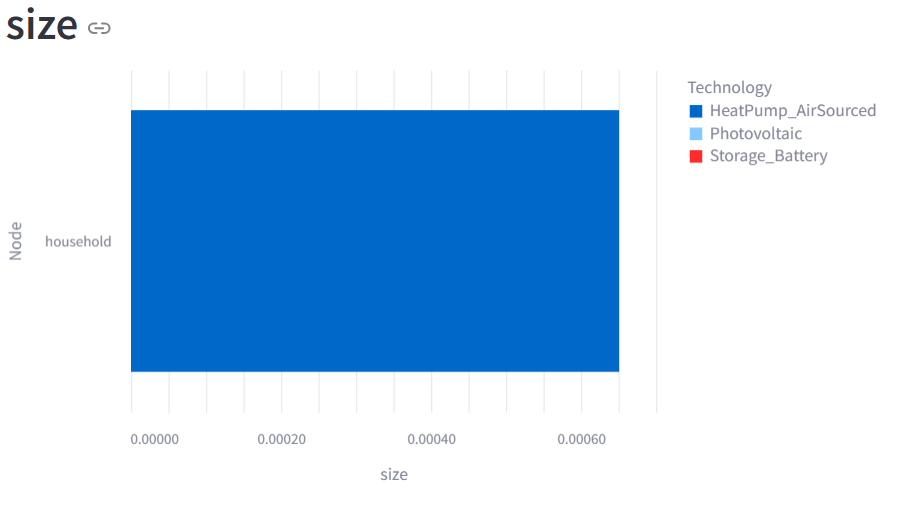
</div>

### Heat pump operation
<div>
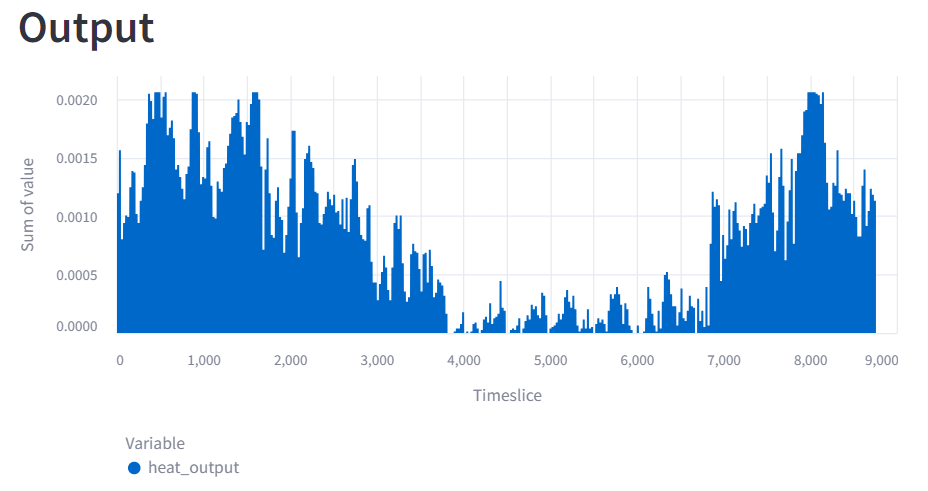
</div>

